# Data Preprocessing

# 1 Load Required Libraries

In [245]:
import src.util as utils
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

# libs required for second attempt
from sklearn.preprocessing import LabelEncoder#, OrdinalEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# 2. Load Configuration File

In [278]:
config = utils.load_config()

# 3. Load Dataset

In [4]:
def load_dataset(config_data: dict):
    # Load every set of data
    x_train = utils.pickle_load(config_data["train_set_path"][0])
    y_train = utils.pickle_load(config_data["train_set_path"][1])

    x_valid = utils.pickle_load(config_data["valid_set_path"][0])
    y_valid = utils.pickle_load(config_data["valid_set_path"][1])

    x_test = utils.pickle_load(config_data["test_set_path"][0])
    y_test = utils.pickle_load(config_data["test_set_path"][1])

    # Concatenate x and y each set
    train_set = pd.concat([x_train, y_train], axis = 1)
    valid_set = pd.concat([x_valid, y_valid], axis = 1)
    test_set = pd.concat([x_test, y_test], axis = 1)

    # Return 3 set of data
    return train_set, valid_set, test_set

In [180]:
train_set, valid_set, test_set = load_dataset(config)

In [6]:
preds = config['predictors']
target = config['target']

In [9]:
train_set.head()

,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,Winner
3314,0,-1,-1,-1,0,1,0,-1,0,-5.08,-2.54,6,1
948,1,0,-1,-3,-2,-12,0,0,-3,2.54,0.00,-1,0
2342,1,-1,0,-1,-3,-1,0,-4,1,0.00,5.08,-2,0
3306,0,0,0,0,-1,-4,0,0,1,5.08,10.16,-5,1
306,1,-1,-1,-1,1,0,0,0,0,-5.08,0.00,3,0


# 4. Balancing Train Label

In [8]:
train_set[target].value_counts()

1    1999
0    1426
Name: Winner, dtype: int64

In [10]:
# we know from our EDA that the label is not balanced
# for that we will perform Random UnderSampling

x_rus, y_rus = RandomUnderSampler(random_state = 99).fit_resample(
    train_set[preds],
    train_set[target]
)
train_set_bal = pd.concat([x_rus, y_rus], axis = 1)

In [11]:
train_set_bal[target].value_counts()

0    1426
1    1426
Name: Winner, dtype: int64

# 5. Scale

In [22]:
scaler = StandardScaler()
scaler.fit(train_set_bal[preds])
scaler_desc_df = pd.DataFrame(
    np.array([scaler.mean_, scaler.var_]),
    columns = scaler.get_feature_names_out(),
    index = ['mean', 'var']
)
scaler_desc_df

,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif
mean,0.179523,0.100281,0.706872,1.401823,0.744390,5.181627,0.297335,0.496844,0.279102,-0.010288,0.172616,0.878682
var,0.996523,2.625287,3.858676,16.232647,7.992518,252.187909,2.353387,4.026287,2.965580,40.664362,70.000055,26.881495


In [52]:
def scale_transform(df: pd.DataFrame, scaler: StandardScaler, preds: list = preds, target: list = target) -> pd.DataFrame:
    df_scaled = pd.DataFrame(scaler.transform(df[preds]),
        index = df.index,
        columns = df[preds].columns
    )
    df_scaled = pd.concat([df_scaled, df[target]], axis=1)

    return df_scaled


In [53]:
train_set_scaled = scale_transform(train_set_bal, scaler)
train_set_scaled

,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,Winner
0,0.821907,-0.061891,-0.868924,-1.092541,-0.970742,-1.081937,-0.193820,-0.247610,-1.904146,0.399928,-0.020632,-0.362349,0
1,0.821907,-0.679071,-0.359850,-0.596137,-1.324461,-0.389261,-0.193820,-2.241070,0.418619,0.001613,0.586544,-0.555222,0
2,0.821907,-0.679071,-0.868924,-0.596137,0.090414,-0.326290,-0.193820,-0.247610,-0.162072,-0.795017,-0.020632,0.409147,0
3,0.821907,-0.061891,-0.359850,-0.347935,0.090414,-0.137378,-0.193820,-0.247610,-0.162072,-0.795017,0.586544,0.216273,0
4,-0.179836,0.555289,0.149224,-0.347935,-1.324461,-0.767084,-0.193820,-0.247610,-0.162072,0.399928,0.282956,-0.169475,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,-0.179836,-0.061891,-0.359850,-0.099733,-0.263305,-0.389261,-0.193820,0.749120,-0.162072,-0.795017,-0.931395,0.216273,1
2848,-0.179836,1.172468,0.658298,0.148469,-0.617024,-0.578173,-0.193820,0.250755,0.999310,-0.396702,0.890132,-0.555222,1
2849,2.825393,-0.061891,-0.868924,-1.588946,-0.263305,-1.081937,-0.845679,-0.745975,-0.742763,0.001613,-0.324219,0.794894,1
2850,-0.179836,-0.061891,-0.359850,-0.347935,-0.263305,-0.326290,-0.193820,-0.247610,-0.162072,0.001613,-1.234983,0.409147,1


In [56]:
dummy_df = pd.DataFrame(scaler.inverse_transform(train_set_scaled[preds]))
dummy_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,0.0,-1.0,-3.0,-2.0,-12.0,0.0,0.0,-3.0,2.54,0.00,-1.0
1,1.0,-1.0,0.0,-1.0,-3.0,-1.0,0.0,-4.0,1.0,0.00,5.08,-2.0
2,1.0,-1.0,-1.0,-1.0,1.0,0.0,0.0,0.0,0.0,-5.08,0.00,3.0
3,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,-5.08,5.08,2.0
4,0.0,1.0,1.0,0.0,-3.0,-7.0,0.0,0.0,0.0,2.54,2.54,0.0


In [57]:
train_set_bal.head()

,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,Winner
0,1,0,-1,-3,-2,-12,0,0,-3,2.54,0.00,-1,0
1,1,-1,0,-1,-3,-1,0,-4,1,0.00,5.08,-2,0
2,1,-1,-1,-1,1,0,0,0,0,-5.08,0.00,3,0
3,1,0,0,0,1,3,0,0,0,-5.08,5.08,2,0
4,0,1,1,0,-3,-7,0,0,0,2.54,2.54,0,0


In [62]:
# data safely inverted, scaler works, we will also apply to valid and test set

valid_set_scaled = scale_transform(valid_set, scaler)
valid_set_scaled.head()

,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,Winner
1351,-0.179836,0.555289,0.149224,-0.099733,0.090414,-0.074408,-0.193820,0.250755,-0.162072,-1.193332,-0.324219,-0.362349,1
820,-0.179836,-0.061891,-0.359850,-0.347935,-0.970742,-0.704114,-0.193820,-0.247610,-0.162072,0.399928,-0.020632,-0.362349,0
663,-0.179836,-0.679071,-0.359850,-0.347935,1.505289,-0.578173,0.458038,0.250755,-1.904146,0.798243,0.586544,0.023399,0
798,-0.179836,6.727085,5.239962,0.893075,-1.678180,1.625799,8.280340,-3.237800,2.741383,0.798243,2.408072,-0.940970,1
135,-2.183322,-0.061891,-0.359850,0.396671,0.444133,0.807181,-0.193820,-0.745975,0.999310,0.798243,0.282956,0.409147,1


In [61]:
test_set_scaled = scale_transform(test_set, scaler)
test_set_scaled.head()

,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,Winner
2827,-0.179836,-0.061891,-0.359850,-0.347935,-0.263305,-0.452231,-0.193820,-0.247610,-0.162072,-0.396702,0.282956,-0.748096,0
3628,0.821907,-0.061891,0.149224,0.396671,0.797852,0.240445,-0.193820,0.250755,0.999310,0.798243,0.890132,0.023399,1
3018,0.821907,-1.296250,0.658298,1.389479,1.505289,1.122034,-0.193820,1.247485,0.418619,0.399928,0.586544,2.145011,0
1481,-0.179836,-1.296250,-1.887072,-3.078158,-3.093056,-2.656203,-0.845679,-1.244340,-1.323454,-0.795017,-0.020632,-2.098213,1
4460,-0.179836,0.555289,1.676445,1.637681,1.505289,1.814710,-0.193820,0.250755,0.418619,-1.193332,-0.627807,-0.362349,0


# 6. Dump

In [66]:
utils.pickle_dump(train_set_scaled[preds], config["train_set_modelready_path"][0])
utils.pickle_dump(train_set_scaled[target], config["train_set_modelready_path"][1])

utils.pickle_dump(valid_set_scaled[preds], config["valid_set_modelready_path"][0])
utils.pickle_dump(valid_set_scaled[target], config["valid_set_modelready_path"][1])

utils.pickle_dump(test_set_scaled[preds], config["test_set_modelready_path"][0])
utils.pickle_dump(test_set_scaled[target], config["test_set_modelready_path"][1])

utils.pickle_dump(scaler, config["scaler_path"])

# \#2 Attempt

In [67]:
# First let's load our dataset afresh
train_set, valid_set, test_set = load_dataset(config)

In [68]:
train_set.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,title_bout,...,finish_round,finish_round_time,total_fight_time_secs,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds,Winner
1386,Joseph Benavidez,Alex Perez,100.0,-120,100.000000,83.333333,11/30/2018,"Las Vegas, Nevada, USA",USA,False,...,1.0,4:19,259.0,195.0,204.0,1015.0,869.0,1100.0,325.0,Red
608,Alexandre Pantoja,Askar Askarov,-210.0,165,47.619048,165.000000,7/18/2020,"Abu Dhabi, Abu Dhabi, United Arab Emirates",United Arab Emirates,False,...,3.0,5:00,900.0,125.0,250.0,600.0,950.0,400.0,1000.0,Blue
2342,Rafael Natal,Tim Boetsch,-145.0,125,68.965517,125.000000,11/12/2016,"New York City, New York, USA",USA,False,...,1.0,3:22,202.0,200.0,475.0,575.0,900.0,350.0,275.0,Blue
3661,Lorenz Larkin,Brad Tavares,-260.0,240,38.461538,240.000000,1/15/2014,"Duluth, Georgia, USA",USA,False,...,3.0,5:00,900.0,110.0,350.0,1478.0,980.0,250.0,730.0,Blue
306,Vince Cachero,Ronnie Lawrence,160.0,-185,160.000000,54.000000,2/27/2021,"Las Vegas, Nevada, USA",USA,False,...,NaN,NaN,NaN,250.0,115.0,900.0,700.0,750.0,600.0,Blue


We still have 119 columns, so we will preprocess some of our features, especially our categorical feature, so that we can perform select best feature for our model.

Kaggle user Yash Sandansing has done similar prediction as what we are doing here, so we'll take some inspiration to how he treat some of the features. His notebook is accessible [here](https://www.kaggle.com/code/yashsandansing/ufc-winner-prediction/notebook)

His result was 77.9% (accuracy score) using Random Forest Classifier, let's see if we can beat it.

In [70]:
# Defining our target feature
target = config['target']
target

'Winner'

Again, for the reason the fight is organized (red is favorite fighter and blue is the underdog) so we'll assign the number 1 for red fighter and 0 for the blue.

In [73]:
le = LabelEncoder()
le.fit(train_set[target])


LabelEncoder()

In [74]:
train_set[target].value_counts()

Red     2001
Blue    1426
Name: Winner, dtype: int64

In [181]:
target_enc = pd.Series(le.transform(train_set[target]), index=train_set.index, name=target)
target_enc.value_counts()

1    2001
0    1426
Name: Winner, dtype: int64

In [183]:
# Encoded correctly, assigning to our dataset

train_set[target] = target_enc
train_set[target].value_counts()

1    2001
0    1426
Name: Winner, dtype: int64

Now for our categoric features.

In [184]:
cat_cols = train_set.select_dtypes([bool, object]).columns
cat_cols

Index(['R_fighter', 'B_fighter', 'date', 'location', 'country', 'title_bout',
       'weight_class', 'gender', 'B_Stance', 'R_Stance', 'better_rank',
       'finish', 'finish_details', 'finish_round_time'],
      dtype='object')

In [113]:
train_set['date']

1386    11/30/2018
608      7/18/2020
2342    11/12/2016
3661     1/15/2014
306      2/27/2021
           ...    
805       7/6/2019
3286    10/25/2014
1449    10/27/2018
3522     5/10/2014
4230     6/22/2012
Name: date, Length: 3427, dtype: object

In [185]:
pd.to_datetime(train_set['date'])

1386   2018-11-30
608    2020-07-18
2342   2016-11-12
3661   2014-01-15
306    2021-02-27
          ...    
805    2019-07-06
3286   2014-10-25
1449   2018-10-27
3522   2014-05-10
4230   2012-06-22
Name: date, Length: 3427, dtype: datetime64[ns]

In [186]:
# Looks good, let's assign it
train_set['date'] = pd.to_datetime(train_set['date'])

In [116]:
train_set['weight_class'].value_counts()

Lightweight              590
Welterweight             579
Middleweight             410
Featherweight            407
Bantamweight             342
Heavyweight              274
Light Heavyweight        272
Flyweight                169
Women's Strawweight      146
Women's Bantamweight     105
Women's Flyweight         99
Catch Weight              23
Women's Featherweight     11
Name: weight_class, dtype: int64

In [117]:
train_set['gender'].value_counts()

MALE      3066
FEMALE     361
Name: gender, dtype: int64

In [120]:
train_set['B_Stance'].value_counts()

Orthodox       2590
Southpaw        677
Switch          158
Open Stance       1
Name: B_Stance, dtype: int64

In [121]:
train_set['better_rank'].value_counts()

neither    2460
Red         918
Blue         49
Name: better_rank, dtype: int64

In [122]:
train_set['finish'].value_counts()

U-DEC         1264
KO/TKO        1037
SUB            577
S-DEC          335
M-DEC           26
DQ              12
Overturned       1
Name: finish, dtype: int64

In [124]:
train_set['finish_details'].value_counts()

Punch                 351
Punches               315
Rear Naked Choke      224
Guillotine Choke      105
Kick                   87
Armbar                 58
Knee                   48
Elbows                 45
Arm Triangle           37
Triangle Choke         34
Elbow                  26
D'Arce Choke           17
Flying Knee            13
Other - Choke          12
Knees                  11
Anaconda Choke         11
Kimura                 10
Heel Hook               9
Kneebar                 9
Slam                    5
Spinning Back Fist      4
North-South Choke       4
Neck Crank              3
Omoplata                2
Kicks                   2
Injury                  2
Spinning Back Kick      2
Keylock                 1
Ankle Lock              1
Other - Lock            1
Name: finish_details, dtype: int64

In [133]:
train_set['finish_round_time'].value_counts()

5:00    1515
4:59      21
2:38      16
2:33      13
2:47      13
        ... 
3:20       1
0:36       1
4:46       1
3:23       1
3:55       1
Name: finish_round_time, Length: 288, dtype: int64

Now let's define some ordinal orderings that we want to impose then encode our categorical data

In [176]:
ordinal_mappings = [
    {'col': 'B_Stance', 'mapping': {'Orthodox': 1, 'Southpaw': -1, 'Switch': 0, 'Open Stance': 0}},
    {'col': 'R_Stance', 'mapping': {'Orthodox': 1, 'Southpaw': -1, 'Switch': 0, 'Open Stance': 0}},
    {'col': 'better_rank', 'mapping': {'Red': 1, 'Blue': -1, 'neither': 0}},
    {'col': 'title_bout', 'mapping': {True: 1, False: 0}}
]

In [187]:
oe_predefined = OrdinalEncoder(mapping=ordinal_mappings)
oe_predefined.fit(train_set)
oe_predefined

OrdinalEncoder(cols=['R_fighter', 'B_fighter', 'location', 'country',
                     'weight_class', 'gender', 'B_Stance', 'R_Stance',
                     'better_rank', 'finish', 'finish_details',
                     'finish_round_time'],
               mapping=[{'col': 'B_Stance',
                         'mapping': {'Open Stance': 0, 'Orthodox': 1,
                                     'Southpaw': -1, 'Switch': 0}},
                        {'col': 'R_Stance',
                         'mapping': {'Open Stance': 0, 'Orthodox': 1,
                                     'Southpaw': -1, 'Switch': 0}},
                        {'col': 'better_rank',
                         'mapping': {'Blue': -1, 'Red': 1, 'neither': 0}},
                        {'col': 'title_bout', 'mapping': {False: 0, True: 1}}])

In [188]:
dummy_df = train_set.copy()
dummy_df = oe_predefined.transform(dummy_df)
dummy_df['B_Stance'].value_counts()

 1.0    2590
-1.0     678
 0.0     159
Name: B_Stance, dtype: int64

In [189]:
# Our OrdinalEncoder works
train_set = dummy_df.copy()

In [190]:
cat_cols = train_set.select_dtypes([bool, object]).columns
cat_cols

Index(['R_fighter', 'B_fighter', 'location', 'country', 'weight_class',
       'gender', 'finish', 'finish_details', 'finish_round_time'],
      dtype='object')

In [191]:
# For the remaining categorical features, we use OrdinalEncoder auto encoder
oe_auto = OrdinalEncoder()
oe_auto.fit(train_set)
oe_auto

OrdinalEncoder(cols=['R_fighter', 'B_fighter', 'location', 'country',
                     'weight_class', 'gender', 'finish', 'finish_details',
                     'finish_round_time'],
               mapping=[{'col': 'R_fighter', 'data_type': dtype('O'),
                         'mapping': Joseph Benavidez         1
Alexandre Pantoja        2
Rafael Natal             3
Lorenz Larkin            4
Vince Cachero            5
                      ... 
Nassourdine Imavov    1194
Albert Cheng          1195
Caludia Gadelha       1196
Te Edwards            1197
NaN                     -2
Length...
North-South Choke     16
Heel Hook             17
D'Arce Choke          18
Elbows                19
Spinning Back Fist    20
Omoplata              21
Anaconda Choke        22
Flying Knee           23
Other - Choke         24
Kicks                 25
Neck Crank            26
Slam                  27
Injury                28
Spinning Back Kick    29
Ankle Lock            30
Other - Lock          31
dtype: int64},
                        {'col': 'finish_round_time', 'data_type': dtype('O'),
                         'mapping': 4:19      1
5:00      2
3:22      3
NaN       4
0:29      5
       ... 
4:23    285
0:17    286
3:58    287
2:34    288
3:55    289
Length: 289, dtype: int64}])

In [192]:
dummy_df = train_set.copy()
dummy_df = oe_auto.transform(dummy_df)
dummy_df.select_dtypes([bool, object]).columns

Index([], dtype='object')

In [193]:
train_set = dummy_df.copy()
train_set.dtypes.value_counts()

float64           59
int64             46
int32             13
datetime64[ns]     1
dtype: int64

In [206]:
train_set['date'].apply(lambda x: x.value)

1386    1543536000000000000
608     1595030400000000000
2342    1478908800000000000
3661    1389744000000000000
306     1614384000000000000
               ...         
805     1562371200000000000
3286    1414195200000000000
1449    1540598400000000000
3522    1399680000000000000
4230    1340323200000000000
Name: date, Length: 3427, dtype: int64

In [207]:
train_set['date'] = train_set['date'].apply(lambda x: x.value)

In [208]:
train_set.dtypes.value_counts()

float64    59
int64      47
int32      13
dtype: int64

Because all of our features now are numeric, let's impute them using their mean.

In [228]:
# Let's look for features that are has no record at all
(train_set.isnull().sum() == len(train_set)).value_counts()

False    118
True       1
dtype: int64

In [229]:
# one feature has no record at all, let's rule it out
train_set.isnull().sum().sort_values(ascending=False)

B_Women's Featherweight_rank    3427
R_Women's Featherweight_rank    3422
B_Pound-for-Pound_rank          3400
B_Women's Flyweight_rank        3399
B_Women's Strawweight_rank      3388
                                ... 
R_draw                             0
R_current_win_streak               0
R_current_lose_streak              0
B_Weight_lbs                       0
Winner                             0
Length: 119, dtype: int64

In [231]:
# it's B_Women's Featherweight_rank that has no value, let's drop it
train_set.drop("B_Women's Featherweight_rank", axis=1, inplace=True)

In [232]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(train_set)
imp

SimpleImputer()

In [233]:
dummy_df = train_set.copy()
dummy_df = pd.DataFrame(imp.transform(dummy_df), index=dummy_df.index, columns=dummy_df.columns)
dummy_df.isnull().sum().loc[lambda x: x>0]

Series([], dtype: int64)

In [239]:
train_set = dummy_df

In [240]:
train_set.corr(method="pearson")['Winner'].apply(lambda x: abs(x)).sort_values(ascending=False)

Winner                          1.000000
B_odds                          0.347473
R_odds                          0.338043
R_ev                            0.326460
B_ev                            0.313042
                                  ...   
empty_arena                     0.000960
B_Flyweight_rank                0.000892
R_Women's Bantamweight_rank     0.000759
constant_1                           NaN
R_Women's Featherweight_rank         NaN
Name: Winner, Length: 118, dtype: float64

In [108]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(train_set.corr(method="pearson")['Winner'].apply(lambda x: abs(x)).sort_values(ascending=False))

Winner                          1.000000
B_odds                          0.347473
R_odds                          0.338043
R_ev                            0.326460
B_Women's Flyweight_rank        0.315761
B_ev                            0.313042
R_Women's Flyweight_rank        0.238749
b_dec_odds                      0.211293
b_ko_odds                       0.206418
r_ko_odds                       0.187173
r_dec_odds                      0.177329
B_Women's Strawweight_rank      0.172712
B_Welterweight_rank             0.171210
R_Heavyweight_rank              0.164204
R_Light Heavyweight_rank        0.154690
b_sub_odds                      0.142813
B_Women's Bantamweight_rank     0.137148
age_dif                         0.129087
B_age                           0.119623
R_Bantamweight_rank             0.119251
r_sub_odds                      0.118681
B_Light Heavyweight_rank        0.114211
R_age                           0.113154
R_Women's Strawweight_rank      0.109216
B_match_weightcl

As we can see above, some of the highly correlated features are odds, ev's, and ranks of some weightclass.

To choose predictors for our model, we are going to experiment with SelectKBest.

In [251]:
x_train, y_train = train_set.drop(target, axis=1), train_set[target]

selector = SelectKBest(score_func=mutual_info_classif, k=20)
selector.fit(x_train, y_train)
selected_features = list(x_train.columns[selector.get_support(indices=True)])

selected_features

['R_odds',
 'B_odds',
 'R_ev',
 'B_ev',
 'gender',
 'B_current_lose_streak',
 'B_avg_TD_pct',
 'R_avg_SIG_STR_pct',
 'R_win_by_Decision_Majority',
 'R_win_by_Decision_Unanimous',
 'avg_sub_att_dif',
 'avg_td_dif',
 "R_Women's Strawweight_rank",
 'R_Welterweight_rank',
 'B_Bantamweight_rank',
 'r_dec_odds',
 'b_dec_odds',
 'b_sub_odds',
 'r_ko_odds',
 'b_ko_odds']

In [255]:
train_set_new = train_set[selected_features+[target]]
train_set_new

,R_odds,B_odds,R_ev,B_ev,gender,B_current_lose_streak,B_avg_TD_pct,R_avg_SIG_STR_pct,R_win_by_Decision_Majority,R_win_by_Decision_Unanimous,...,avg_td_dif,R_Women's Strawweight_rank,R_Welterweight_rank,B_Bantamweight_rank,r_dec_odds,b_dec_odds,b_sub_odds,r_ko_odds,b_ko_odds,Winner
1386,100.0,-120.0,100.000000,83.333333,1.0,0.0,0.350000,0.350000,0.0,7.0,...,1.266667,6.973333,6.838384,8.275862,195.0,204.0,869.000000,1100.000000,325.000000,1.0
608,-210.0,165.0,47.619048,165.000000,1.0,0.0,0.220000,0.470000,0.0,1.0,...,0.900000,6.973333,6.838384,8.275862,125.0,250.0,950.000000,400.000000,1000.000000,0.0
2342,-145.0,125.0,68.965517,125.000000,1.0,0.0,0.207368,0.481333,0.0,5.0,...,-1.294737,6.973333,6.838384,8.275862,200.0,475.0,900.000000,350.000000,275.000000,0.0
3661,-260.0,240.0,38.461538,240.000000,1.0,0.0,0.260000,0.385000,0.0,1.0,...,1.571429,6.973333,6.838384,8.275862,110.0,350.0,980.000000,250.000000,730.000000,0.0
306,160.0,-185.0,160.000000,54.000000,1.0,0.0,0.760000,0.450000,0.0,0.0,...,10.860000,6.973333,6.838384,8.275862,250.0,115.0,700.000000,750.000000,600.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,-200.0,170.0,50.000000,170.000000,2.0,0.0,0.270000,0.420000,0.0,3.0,...,-1.960000,6.973333,6.838384,8.275862,-130.0,235.0,1350.000000,960.000000,1900.000000,1.0
3286,-405.0,360.0,24.691358,360.000000,1.0,0.0,0.312829,0.310000,0.0,1.0,...,-2.000000,6.973333,6.838384,8.275862,254.0,556.0,2000.000000,335.000000,698.000000,1.0
1449,-450.0,360.0,22.222222,360.000000,1.0,0.0,0.312829,0.454820,0.0,0.0,...,0.000000,6.973333,6.838384,8.275862,565.0,600.0,1325.000000,-190.000000,950.000000,0.0
3522,-295.0,265.0,33.898305,265.000000,1.0,0.0,0.300000,0.404000,0.0,1.0,...,0.833333,6.973333,6.838384,8.275862,175.0,523.0,2650.000000,160.000000,1375.000000,0.0


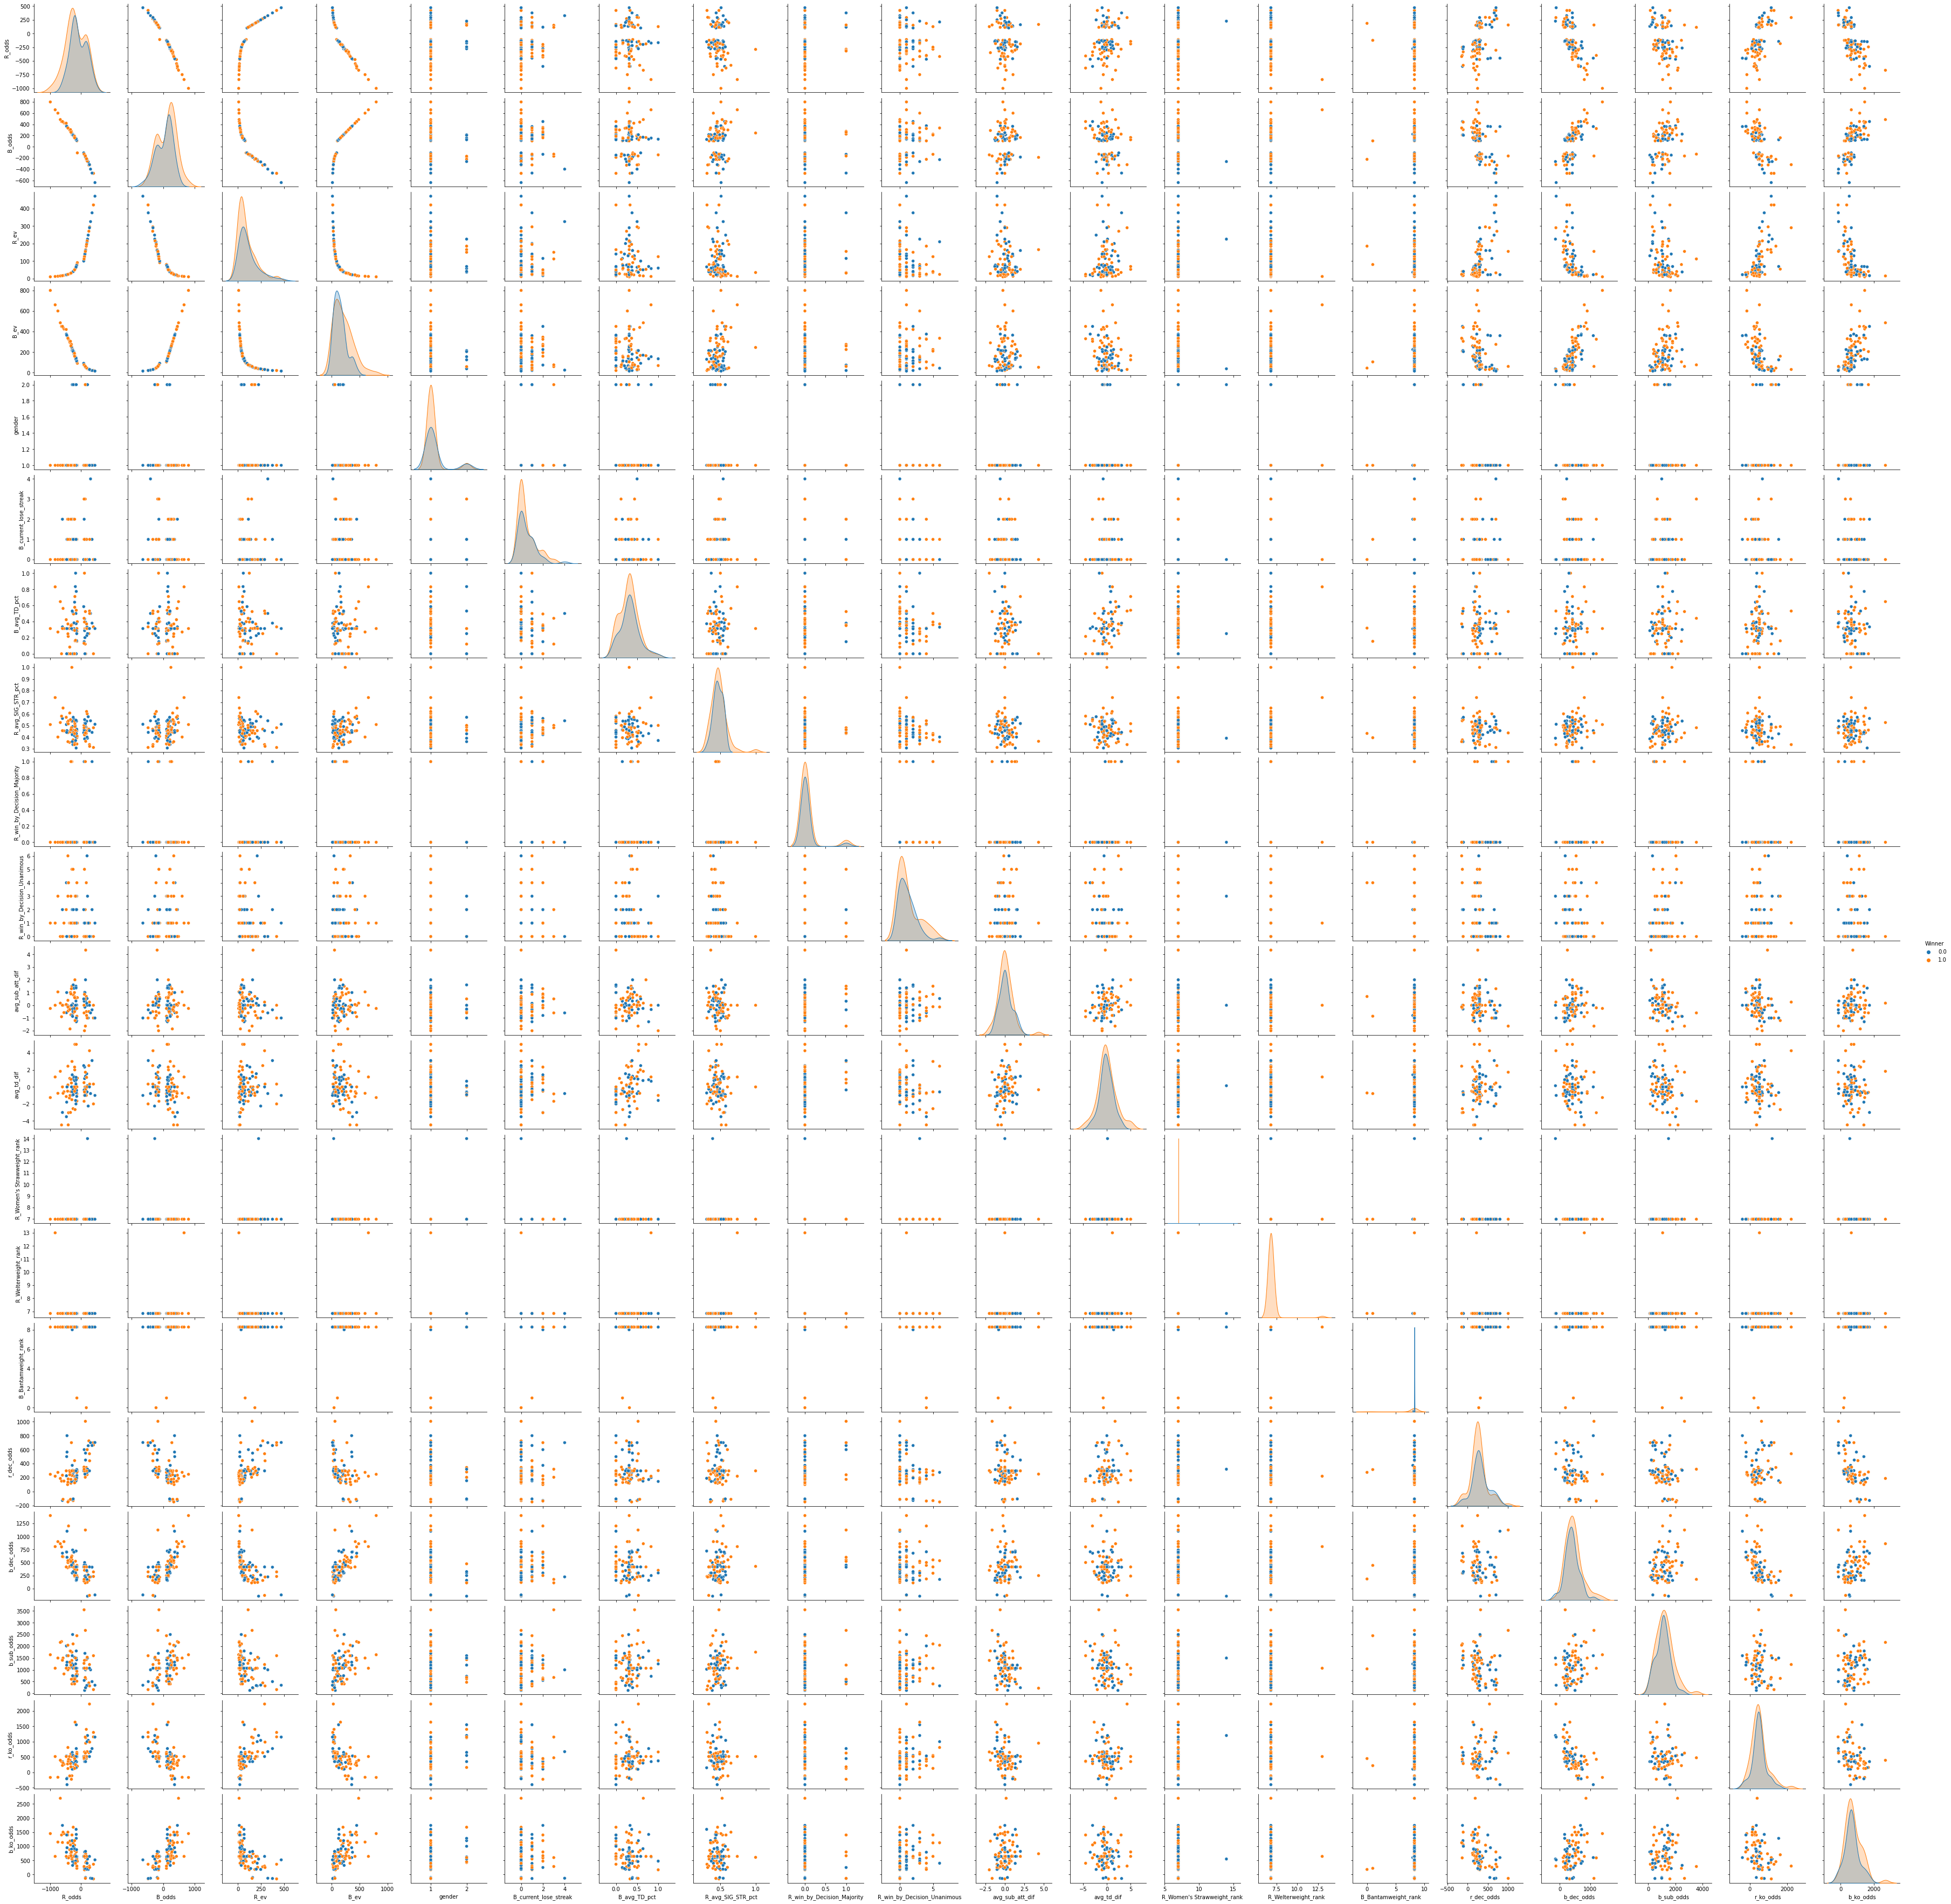

In [256]:
sns.pairplot(train_set_new.sample(100),hue = target)

Balancing train dataset

In [257]:
x_rus, y_rus = RandomUnderSampler(random_state = 99).fit_resample(
    train_set[selected_features],
    train_set[target]
)
train_set_bal = pd.concat([x_rus, y_rus], axis = 1)
train_set_bal[target].value_counts()

0.0    1426
1.0    1426
Name: Winner, dtype: int64

Scaling train dataset

In [258]:
scaler = StandardScaler()
scaler.fit(train_set_bal[selected_features])
scaler_desc_df = pd.DataFrame(
    np.array([scaler.mean_, scaler.var_]),
    columns = scaler.get_feature_names_out(),
    index = ['mean', 'var']
)
scaler_desc_df

,R_odds,B_odds,R_ev,B_ev,gender,B_current_lose_streak,B_avg_TD_pct,R_avg_SIG_STR_pct,R_win_by_Decision_Majority,R_win_by_Decision_Unanimous,avg_sub_att_dif,avg_td_dif,R_Women's Strawweight_rank,R_Welterweight_rank,B_Bantamweight_rank,r_dec_odds,b_dec_odds,b_sub_odds,r_ko_odds,b_ko_odds
mean,-99.945302,48.090813,100.272255,158.29742,1.101332,0.477560,0.313599,0.453106,0.025596,1.444250,-0.045023,-0.163636,6.980538,6.835554,8.275052,303.139406,404.591363,1053.403395,526.711955,630.247287
var,70174.904441,61581.396732,7462.569577,17244.05596,0.091064,0.576986,0.050869,0.010821,0.025642,3.302292,0.727667,2.934828,0.471917,0.615105,0.286519,43770.744374,73808.533572,306619.950889,140930.365604,157990.167684


In [260]:
train_set_scaled = scale_transform(train_set_bal, scaler, preds=selected_features)
train_set_scaled.head()

,R_odds,B_odds,R_ev,B_ev,gender,B_current_lose_streak,B_avg_TD_pct,R_avg_SIG_STR_pct,R_win_by_Decision_Majority,R_win_by_Decision_Unanimous,...,avg_td_dif,R_Women's Strawweight_rank,R_Welterweight_rank,B_Bantamweight_rank,r_dec_odds,b_dec_odds,b_sub_odds,r_ko_odds,b_ko_odds,Winner
0,-0.415449,0.471112,-0.609510,0.051041,-0.335795,-0.628702,-0.415001,0.162408,-0.159844,-0.244467,...,0.620872,-0.010487,0.003608,0.001513,-0.851467,-0.569026,-0.186739,-0.337532,0.930243,0.0
1,-0.170078,0.309923,-0.362405,-0.253566,-0.335795,-0.628702,-0.471007,0.271357,-0.159844,1.956697,...,-0.660252,-0.010487,0.003608,0.001513,-0.492984,0.259163,-0.277035,-0.470721,-0.893749,0.0
2,-0.604196,0.773341,-0.715516,0.622180,-0.335795,-0.628702,-0.237649,-0.654711,-0.159844,-0.244467,...,1.012802,-0.010487,0.003608,0.001513,-0.923164,-0.200942,-0.132561,-0.737099,0.250963,0.0
3,0.981276,-0.939291,0.691404,-0.794244,-0.335795,-0.628702,1.979248,-0.029856,-0.159844,-0.794757,...,6.434778,-0.010487,0.003608,0.001513,-0.253995,-1.065939,-0.638220,0.594789,-0.076098,0.0
4,-1.094937,1.208551,-0.863926,1.444620,-0.335795,-0.628702,-0.003414,-2.048619,-0.159844,-0.794757,...,0.095519,-0.010487,0.003608,0.001513,-0.031850,0.038532,0.025716,-0.028222,0.030081,0.0


Now let's dump our preprocessed data.

In [272]:
def preprocess_dataset(
    dataset_in: pd.DataFrame,
    label_encoder: LabelEncoder = le,
    ordinal_encoder_predefined: OrdinalEncoder = oe_predefined, 
    ordinal_encoder_auto: OrdinalEncoder = oe_auto,
    imputer: SimpleImputer = imp, 
    scaler: StandardScaler = scaler):

    dataset = dataset_in.copy()

    dataset[target] = pd.Series(label_encoder.transform(dataset[target]), index=dataset.index, name=target)
    dataset['date'] = pd.to_datetime(dataset['date']).apply(lambda x: x.value)
    dataset = ordinal_encoder_predefined.transform(dataset)
    dataset = ordinal_encoder_auto.transform(dataset)
    dataset.drop("B_Women's Featherweight_rank", axis=1, inplace=True)
    dataset = pd.DataFrame(imputer.transform(dataset), index=dataset.index, columns=dataset.columns)
    dataset = dataset[selected_features+[target]]
    dataset = scale_transform(dataset, scaler, preds=selected_features)

    return dataset

In [273]:
valid_set_new = preprocess_dataset(dataset_in=valid_set)
valid_set_new.head()

,R_odds,B_odds,R_ev,B_ev,gender,B_current_lose_streak,B_avg_TD_pct,R_avg_SIG_STR_pct,R_win_by_Decision_Majority,R_win_by_Decision_Unanimous,...,avg_td_dif,R_Women's Strawweight_rank,R_Welterweight_rank,B_Bantamweight_rank,r_dec_odds,b_dec_odds,b_sub_odds,r_ko_odds,b_ko_odds,Winner
1344,-0.245577,0.390517,-0.459173,-0.101262,-0.335795,0.687787,-0.178532,-0.138004,-0.159844,-0.794757,...,0.265772,-0.010487,0.003608,0.001513,-0.492984,-0.753068,0.625928,-0.763736,1.433413,1.0
820,0.943526,-0.878846,0.575645,-0.757512,-0.335795,-0.628702,0.516096,-0.414382,-0.159844,0.305824,...,3.014146,-0.010487,0.003608,0.001513,-0.301793,-2.022957,1.528890,1.127545,1.056035,0.0
663,0.830278,-0.717657,0.228367,-0.619680,2.978005,-0.628702,0.516096,-0.702777,-0.159844,0.305824,...,0.895223,-0.010487,0.003608,0.001513,-0.583800,-0.565345,-1.461722,1.063614,0.804450,0.0
793,-0.151204,0.289774,-0.333892,-0.291642,2.978005,2.004277,-1.390435,-0.318250,-0.159844,-0.794757,...,-0.680836,-0.010487,0.003608,0.001513,-0.827569,-0.962875,2.070668,2.858999,1.420834,1.0
4547,0.758555,-0.641092,0.008424,-0.519411,-0.335795,-0.628702,1.203334,-0.414382,-0.159844,-0.794757,...,1.554832,-0.010487,0.003608,0.001513,-0.031850,0.038532,0.025716,-0.028222,0.030081,1.0


In [275]:
test_set_new = preprocess_dataset(dataset_in=test_set)
test_set_new.head()

,R_odds,B_odds,R_ev,B_ev,gender,B_current_lose_streak,B_avg_TD_pct,R_avg_SIG_STR_pct,R_win_by_Decision_Majority,R_win_by_Decision_Unanimous,...,avg_td_dif,R_Women's Strawweight_rank,R_Welterweight_rank,B_Bantamweight_rank,r_dec_odds,b_dec_odds,b_sub_odds,r_ko_odds,b_ko_odds,Winner
2827,-0.868441,0.894233,-0.809959,0.850635,-0.335795,0.687787,-1.390435,0.450802,-0.159844,-0.794757,...,0.095519,-0.010487,0.003608,0.001513,-0.301793,0.332780,0.165417,-0.763736,0.678658,0.0
3226,-0.849566,0.994976,-0.804562,1.041015,-0.335795,-0.628702,2.005851,-0.785175,-0.159844,-0.244467,...,0.695922,-0.010487,0.003608,0.001513,-0.301793,0.719268,0.445335,-0.737099,-0.705061,1.0
3018,1.377644,-1.503453,1.906876,-0.971150,-0.335795,-0.628702,1.735389,-0.551713,-0.159844,0.305824,...,1.513138,-0.010487,0.003608,0.001513,1.849109,-0.786195,-1.432827,0.461601,-1.032121,0.0
4644,-0.717443,0.853935,-0.761574,0.774484,-0.335795,-0.628702,-0.651470,-0.377408,-0.159844,0.856115,...,-0.420854,-0.010487,0.003608,0.001513,-0.031850,0.038532,0.025716,-0.028222,0.030081,1.0
4460,-0.736318,0.874084,-0.768340,0.812560,-0.335795,-0.628702,-0.003414,-0.636224,-0.159844,1.956697,...,-0.802521,-0.010487,0.003608,0.001513,-0.031850,0.038532,0.025716,-0.028222,0.030081,0.0


In [279]:
utils.pickle_dump(train_set_scaled[selected_features], config["train_set_modelready_path"][0])
utils.pickle_dump(train_set_scaled[target], config["train_set_modelready_path"][1])

utils.pickle_dump(valid_set_new[selected_features], config["valid_set_modelready_path"][0])
utils.pickle_dump(valid_set_new[target], config["valid_set_modelready_path"][1])

utils.pickle_dump(test_set_new[selected_features], config["test_set_modelready_path"][0])
utils.pickle_dump(test_set_new[target], config["test_set_modelready_path"][1])

utils.pickle_dump(le, config['label_encoder_path'])
utils.pickle_dump(oe_predefined, config['ordinal_encoder_path'][0])
utils.pickle_dump(oe_auto, config['ordinal_encoder_path'][1])
utils.pickle_dump(imp, config['imputer_path'])
utils.pickle_dump(scaler, config["scaler_path"])
